In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

In [72]:
#KL weights: logistic function 
lw_df = pd.read_csv('logistic_KL_annealing_mdl.csv')

#KL weights: constant = 1
cw_df = pd.read_csv('constant_KL_annealing_mdl.csv')

In [73]:
lw_df_train = lw_df[lw_df['split'] == 'train']
cw_df_train = cw_df[cw_df['split'] == 'train']

## KL Annealing weights - Constant = 1 (Training)

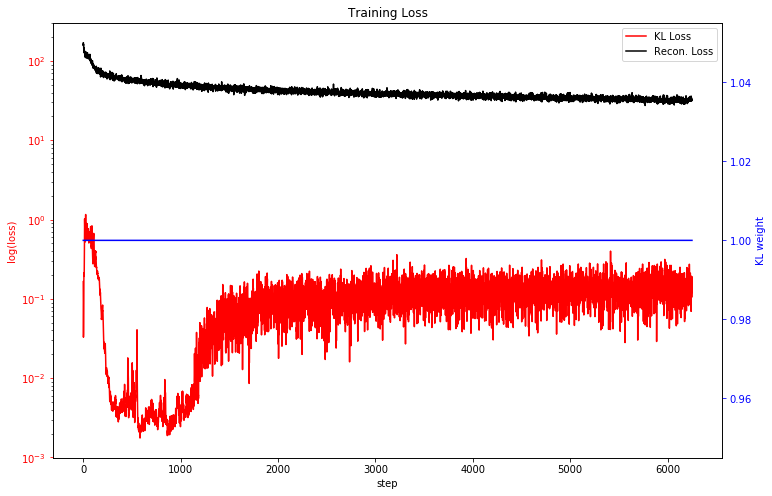

In [95]:
fig, ax1 = plt.subplots()
t = cw_df_train.step

s1 = cw_df_train.kl_loss
s2 = cw_df_train.nll_loss
ax1.plot(t,s1,'r-',label='KL Loss')
ax1.plot(t,s2,'k-',label='Recon. Loss')
ax1.set_xlabel('step')
ax1.set_ylabel('log(loss)',color = 'r')
ax1.set_yscale("log")
ax1.tick_params('y',colors='r')
ax1.legend()

ax2 = ax1.twinx()
s3 = cw_df_train.kl_weight
ax2.plot(t,s3,'b-',label='1234')
ax2.set_ylabel('KL weight',color = 'b')
ax2.tick_params('y',colors='b')

plt.title('Training Loss')
plt.show()

<font color='red'><font size = '3'> COMMENTS </font>
* During the training, KL loss is negligible comparing to reconstruction loss.
* Without KL annealing, VAE failed to encode information into z.
* The model is effectively equivalent to a RNNLM with initial hidden state as random noise

## KL Annealing weight - Sigmoid Function (Training)

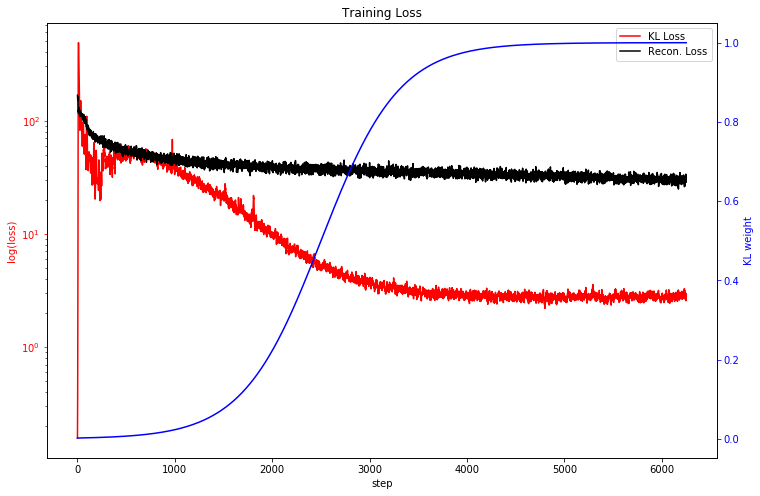

In [119]:
fig, ax1 = plt.subplots()
t = lw_df_train.step

s1 = lw_df_train.kl_loss
s2 = lw_df_train.nll_loss
ax1.plot(t,s1,'r-',label = 'KL Loss')
ax1.plot(t,s2,'k-',label = 'Recon. Loss')
ax1.set_xlabel('step')
ax1.set_ylabel('log(loss)',color = 'r')
ax1.set_yscale("log")
ax1.tick_params('y',colors='r')
ax1.legend()

ax2 = ax1.twinx()
s3 = lw_df_train.kl_weight
ax2.plot(t,s3,'b-')
ax2.set_ylabel('KL weight',color = 'b')
ax2.tick_params('y',colors='b')

plt.title('Training Loss')
plt.show()

<font color='red'><font size = '3'> COMMENTS </font>
* No regularization at beginning, model is given the freedom to encode as much information in z as it can
* The KL loss descends with the increase of weight on KL loss.
* After annealing weight back to 1, KL loss seems to slowly climb up 

## KL Annealing weights - Constant = 1 (Training)

In [100]:
cw_df_valid = cw_df[cw_df['split'] == 'valid']
lw_df_valid = lw_df[lw_df['split'] == 'valid']

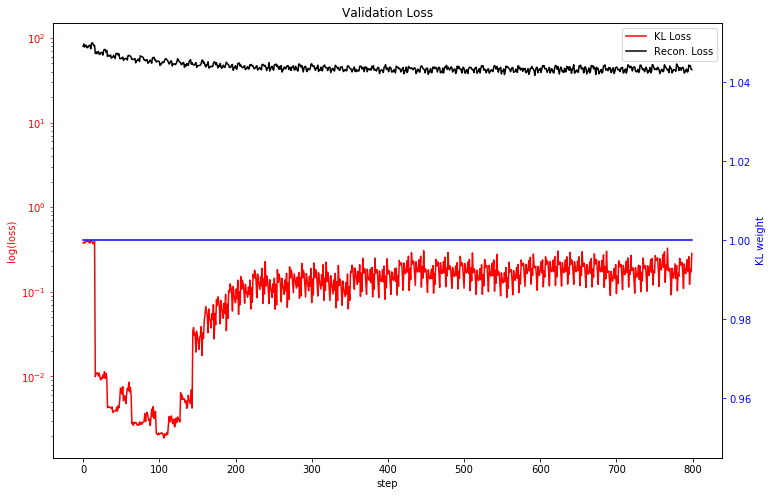

In [105]:
fig, ax1 = plt.subplots()
t = range(cw_df_valid.shape[0])

s1 = cw_df_valid.kl_loss
s2 = cw_df_valid.nll_loss
ax1.plot(t,s1,'r-',label='KL Loss')
ax1.plot(t,s2,'k-',label='Recon. Loss')
ax1.set_xlabel('step')
ax1.set_ylabel('log(loss)',color = 'r')
ax1.set_yscale("log")
ax1.tick_params('y',colors='r')
ax1.legend()

ax2 = ax1.twinx()
s3 = cw_df_valid.kl_weight
ax2.plot(t,s3,'b-',label='1234')
ax2.set_ylabel('KL weight',color = 'b')
ax2.tick_params('y',colors='b')

plt.title('Validation Loss')
plt.show()

## KL Annealing weight - Sigmoid Function (Validation)

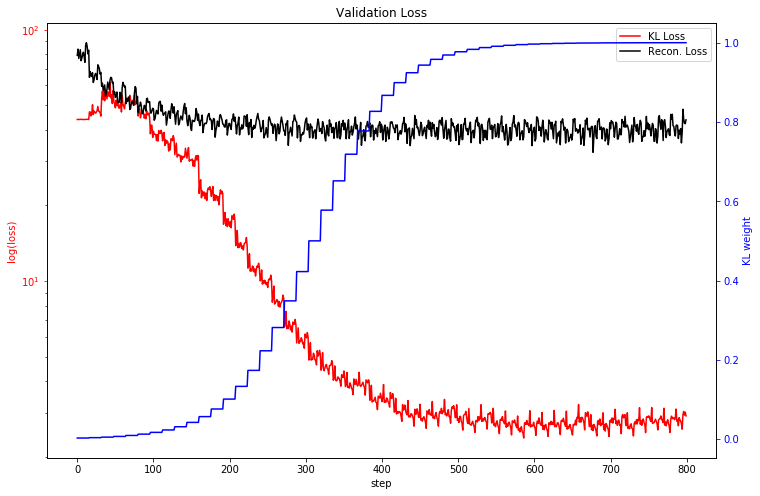

In [106]:
fig, ax1 = plt.subplots()
t = range(lw_df_valid.shape[0])

s1 = lw_df_valid.kl_loss
s2 = lw_df_valid.nll_loss
ax1.plot(t,s1,'r-',label='KL Loss')
ax1.plot(t,s2,'k-',label='Recon. Loss')
ax1.set_xlabel('step')
ax1.set_ylabel('log(loss)',color = 'r')
ax1.set_yscale("log")
ax1.tick_params('y',colors='r')
ax1.legend()

ax2 = ax1.twinx()
s3 = lw_df_valid.kl_weight
ax2.plot(t,s3,'b-',label='1234')
ax2.set_ylabel('KL weight',color = 'b')
ax2.tick_params('y',colors='b')

plt.title('Validation Loss')
plt.show()

## ELBO Plot

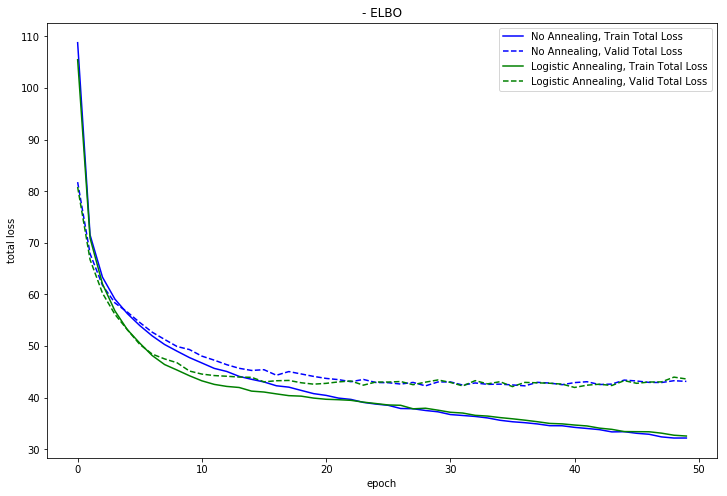

In [148]:
train_epoch_avg_tot_loss_c = cw_df_train.groupby(['epoch']).mean().tot_loss
valid_epoch_avg_tot_loss_c = cw_df_valid.groupby(['epoch']).mean().tot_loss
train_epoch_avg_tot_loss_l = lw_df_train.groupby(['epoch']).mean().tot_loss
valid_epoch_avg_tot_loss_l = lw_df_valid.groupby(['epoch']).mean().tot_loss

fig, ax1 = plt.subplots()
t = range(len(train_epoch_avg_tot_loss))

s1 = train_epoch_avg_tot_loss_c
s2 = valid_epoch_avg_tot_loss_c
s3 = train_epoch_avg_tot_loss_l
s4 = valid_epoch_avg_tot_loss_l
ax1.plot(t,s1,'b-',label='No Annealing, Train Total Loss')
ax1.plot(t,s2,'b--',label='No Annealing, Valid Total Loss')
ax1.plot(t,s3,'g-',label='Logistic Annealing, Train Total Loss')
ax1.plot(t,s4,'g--',label='Logistic Annealing, Valid Total Loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('total loss')
ax1.legend()

plt.title('- ELBO')
plt.show()

<font color='red'><font size = '3'> COMMENTS </font>
* No improvement on validation data after 10 epochs
* KL annealing with logistic function seems to affect converging speed

## SMIELS Sampling - Logistic KL Annealing

* Model 1: trained with logistic KL annealing
* Model 2: trained with constant weight = 1

* use trained models to generate 1,000 SMIELS with random N(0,I) as inputs
* compare their results

In [178]:
import json
import os
import torch
import rdkit
from rdkit import Chem

In [179]:
def smile_generator(directory, vocab_file, model_file, nsample, max_sequence_length):

    w2i, i2w = idx2word(directory, vocab_file)

    eos_idx = w2i['<eos>']

    model = torch.load(model_file)
    model.eval()  # model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval model instead of training mode.

    samples_idx, z = model.inference(n=nsample)

    smiles_lst = []
    for i in range(nsample):
        smiles = []
        for j in range(max_sequence_length):
            if samples_idx[i,j] == eos_idx:
                break
            smiles.append(i2w[samples_idx[i,j].item()])
        smiles = "".join(smiles)
        smiles_lst.append(smiles)
    return smiles_lst, z
    

            
def idx2word(directory, vocab_file):
    w2i = dict()
    i2w = dict()

    # add special tokens to vocab
    special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
    for st in special_tokens:
        i2w[len(w2i)] = st
        w2i[st] = len(w2i)

    # load unique chars
    char_list = json.load(open(os.path.join(directory, vocab_file)))
    for i, c in enumerate(char_list):
        i2w[len(w2i)] = c
        w2i[c] = len(w2i)

    return w2i, i2w

In [180]:
data_dir = "/Users/keyu/PycharmProjects/DrugEmbedding/data/"
vocab_file = "zinc_char_list.json"
nsample = 1000
max_sequence_length = 120
vae_smiles_sample, z = smile_generator(data_dir, vocab_file, 'logistic_KL_annealing_mdl', nsample, max_sequence_length)

In [181]:
unique_vae_smiles = list(set(vae_smiles_sample))

In [182]:
len(unique_vae_smiles)

375

In [184]:
smi_freq_lst = []
for smi in unique_vae_smiles:
    #count of duplicate smiles
    smi_cnt = vae_smiles_sample.count(smi)
    
    #valid or invalide
    if type(Chem.MolFromSmiles(smi)) is rdkit.Chem.rdchem.Mol:
        smi_valid = 1
    else:
        smi_valid = 0
        
    smi_freq_lst.append([smi, smi_cnt, smi_valid])
smi_freq_df = pd.DataFrame(smi_freq_lst,columns = ['VAE_SMILES','COUNT','VALID'])

In [185]:
smi_freq_df.sort_values(by=['COUNT'], ascending=False)

,VAE_SMILES,COUNT,VALID
187,C[C@H](CC(=O)c1ccc(Cl)cc1)C(=O)N1CCC[C@H](C(F)...,31,1
248,Cc1ccc(C(=O)N2CCC[C@H](C(=O)Nc3ccc(F)cc3)C2)cc1,28,1
209,Cc1ccc(C(=O)N2CCC[C@@H](c3nnc(Cn4cccn4)n3C)C2)cc1,28,1
110,COc1ccc(C)cc1NC(=O)C(=O)Nc1ccc(C(=O)NC(C)C)cc1,27,1
324,CCC[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)NC(C)C)cc1,21,1
349,COc1ccc(C(=O)N2CCC[C@H](C(=O)Nc3ccc(F)cc3)C2)c...,21,1
315,CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)NC(C...,18,1
115,C[C@H](CCCO)Nc1ccc(C(=O)NC(C)C)cc1,17,1
182,COC(=O)c1ccc(CN2CC[NH+](Cc3ccccc3)CC2)cc1,13,1
250,CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(C(F)(F)...,12,1


In [186]:
#check validity
print('%d VAE generated SMILES are valid molecules'%smi_freq_df['VALID'].sum())

310 VAE generated SMILES are valid molecules


<font color='red'><font size = '3'> COMMENTS </font>
* duplicated SMILES may imply dead field in Z space, no X information was encoded into those fields
* Small training sample, validation loss plateaued after 10 epochs
* need to tune hyperparameters
* it may also caused by greedy sampling strategy which picks the most likely next letter at each RNN cell 
* 310 out 375 (or 83%) sampled SMILES are valid

## SMIELS Sampling - Constant weight = 1

In [187]:
data_dir = "/Users/keyu/PycharmProjects/DrugEmbedding/data/"
vocab_file = "zinc_char_list.json"
nsample = 1000
max_sequence_length = 120
vae_smiles_sample, z = smile_generator(data_dir, vocab_file, 'constant_KL_annealing_mdl', nsample, max_sequence_length)

In [188]:
unique_vae_smiles = list(set(vae_smiles_sample))

In [189]:
len(unique_vae_smiles)

10

In [190]:
smi_freq_lst = []
for smi in unique_vae_smiles:
    #count of duplicate smiles
    smi_cnt = vae_smiles_sample.count(smi)
    
    #valid or invalide
    if type(Chem.MolFromSmiles(smi)) is rdkit.Chem.rdchem.Mol:
        smi_valid = 1
    else:
        smi_valid = 0
        
    smi_freq_lst.append([smi, smi_cnt, smi_valid])
smi_freq_df = pd.DataFrame(smi_freq_lst,columns = ['VAE_SMILES','COUNT','VALID'])

In [191]:
smi_freq_df.sort_values(by=['COUNT'], ascending=False)

,VAE_SMILES,COUNT,VALID
4,CC(C)C[C@H](C)NC(=O)NCC(C)(C)c1ccccc1,895,1
1,CCCCN(C)C(=O)CCc1ccc(C(=O)NCC(=O)NC)cc1,70,1
7,O=C(NCCC(=O)N1CCCCC1)N1CCCCC1,15,1
9,CCCCC(=O)NCCC(=O)Nc1cccc(C(F)(F)F)c1,12,1
3,O=C(NCCN(Cc1ccccc1)C1CC1)CC1(C#N)CCCC1,2,1
6,CCC(=O)Nc1ccc(C(=O)Nc2ccc(C(C)=O)cc2C(=O)[O-])...,2,1
0,CCCCC(=O)NCCCC(=O)NC(C)(C)C,1,1
2,CCC[C@@H](C)NC(=O)NCC(C)(C)c1ccccc1,1,1
5,CC(C)(C)OC(=O)NC[C@H]1CCC[NH+](Cc2ccc(C)cc2)C1,1,1
8,O=C(NCCCN1CCOCC1)c1ccc(Cl)cc1Cl,1,1


In [192]:
#check validity
print('%d VAE generated SMILES are valid molecules'%smi_freq_df['VALID'].sum())

10 VAE generated SMILES are valid molecules


<font color='red'><font size = '3'> COMMENTS </font>
* no KL annealing result even more severe duplication
* this shows most Z space are dead or produce "noise" for decoder
* little information has been encoded into Z